In [1]:
from datasets import load_dataset, concatenate_datasets
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# dataset = load_dataset("nlphuji/flickr30k").with_format("numpy")
# sample = dataset['test'].select(range(100))

/Users/amirjabarivasal/Documents/MLX/week4/week4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
# Filter samples with height < 256
small_samples = sample.filter(lambda x: x['image'].shape[0] < 256)
small_selection = small_samples.select(range(10))

# Filter samples with height > 500
large_samples = sample.filter(lambda x: x['image'].shape[0] > 500)
large_selection = large_samples.select(range(10))

# Concatenate the selections
sample = concatenate_datasets([small_selection, large_selection])

Filter: 100%|██████████| 10000/10000 [00:17<00:00, 573.37 examples/s]


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

(230, 500, 3)
(500, 500, 3)


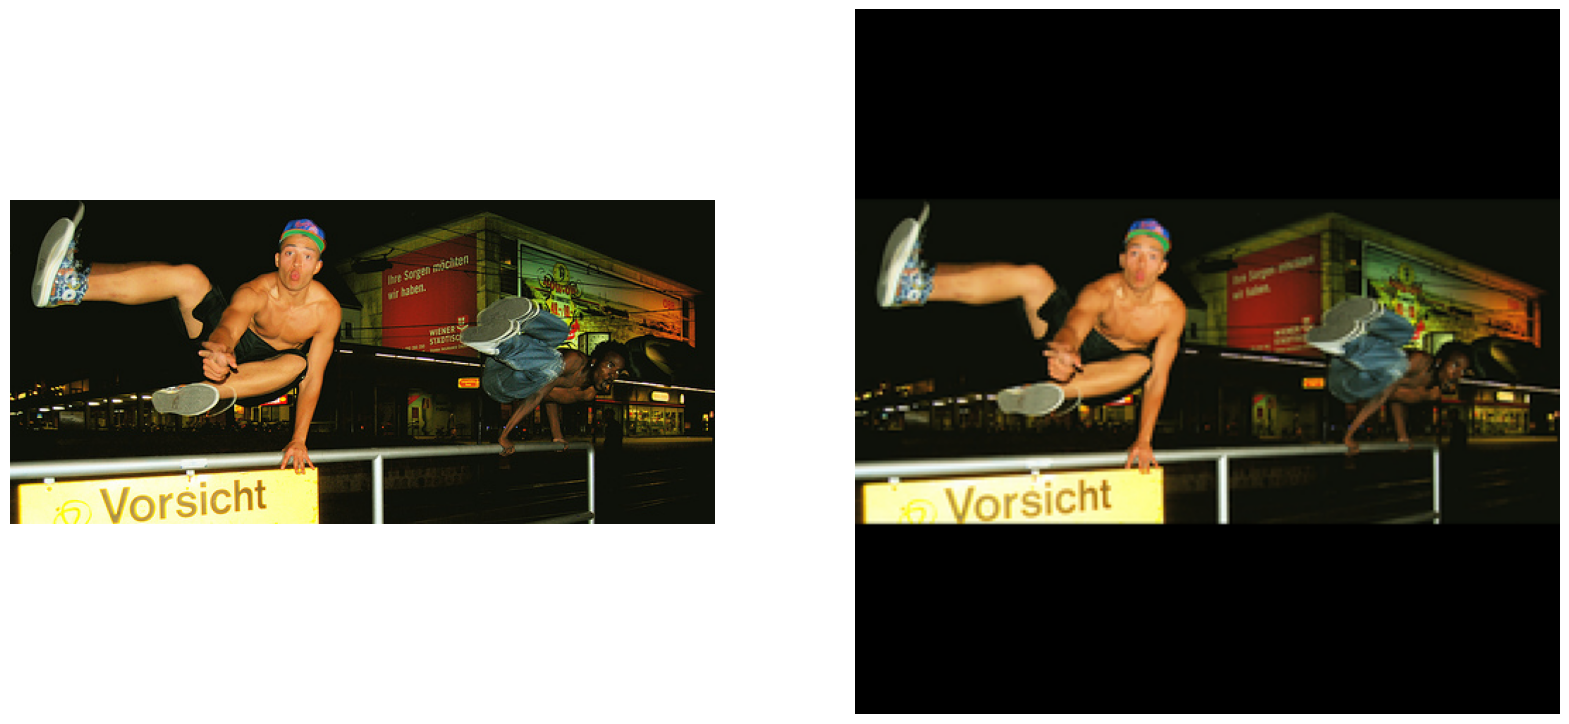

(198, 500, 3)
(500, 500, 3)


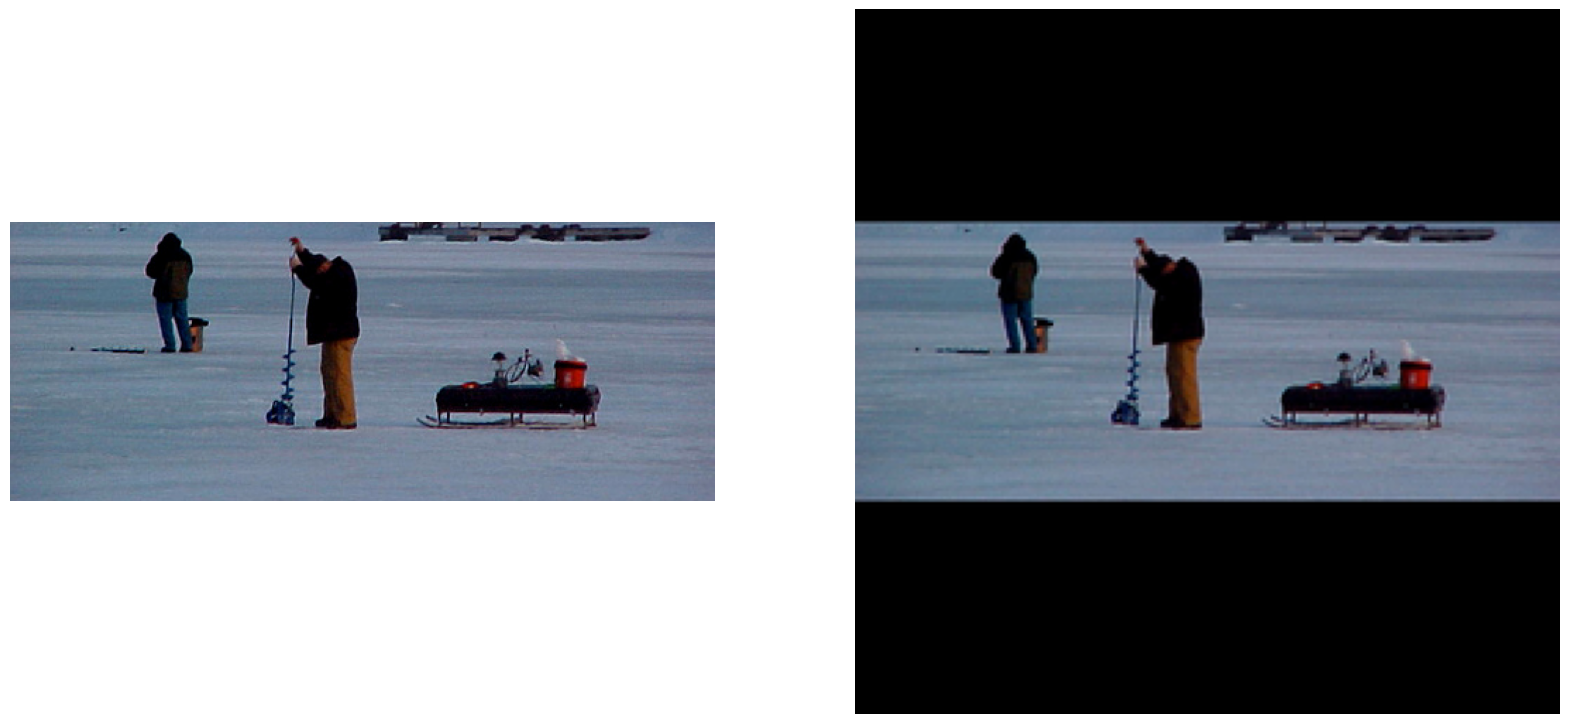

Map:  20%|██        | 2/10 [00:00<00:00, 10.21 examples/s]

(215, 500, 3)
(500, 500, 3)


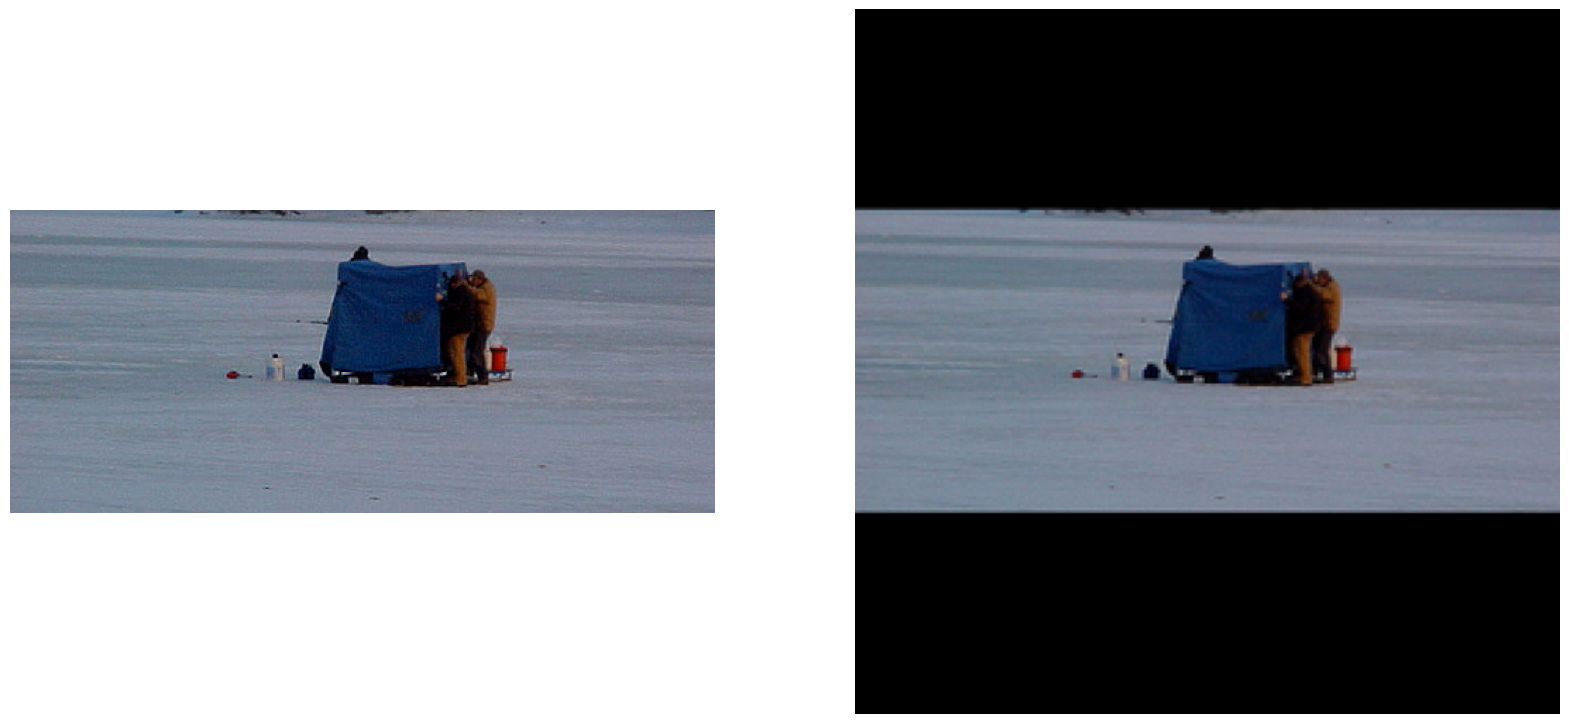

(224, 320, 3)
(320, 320, 3)


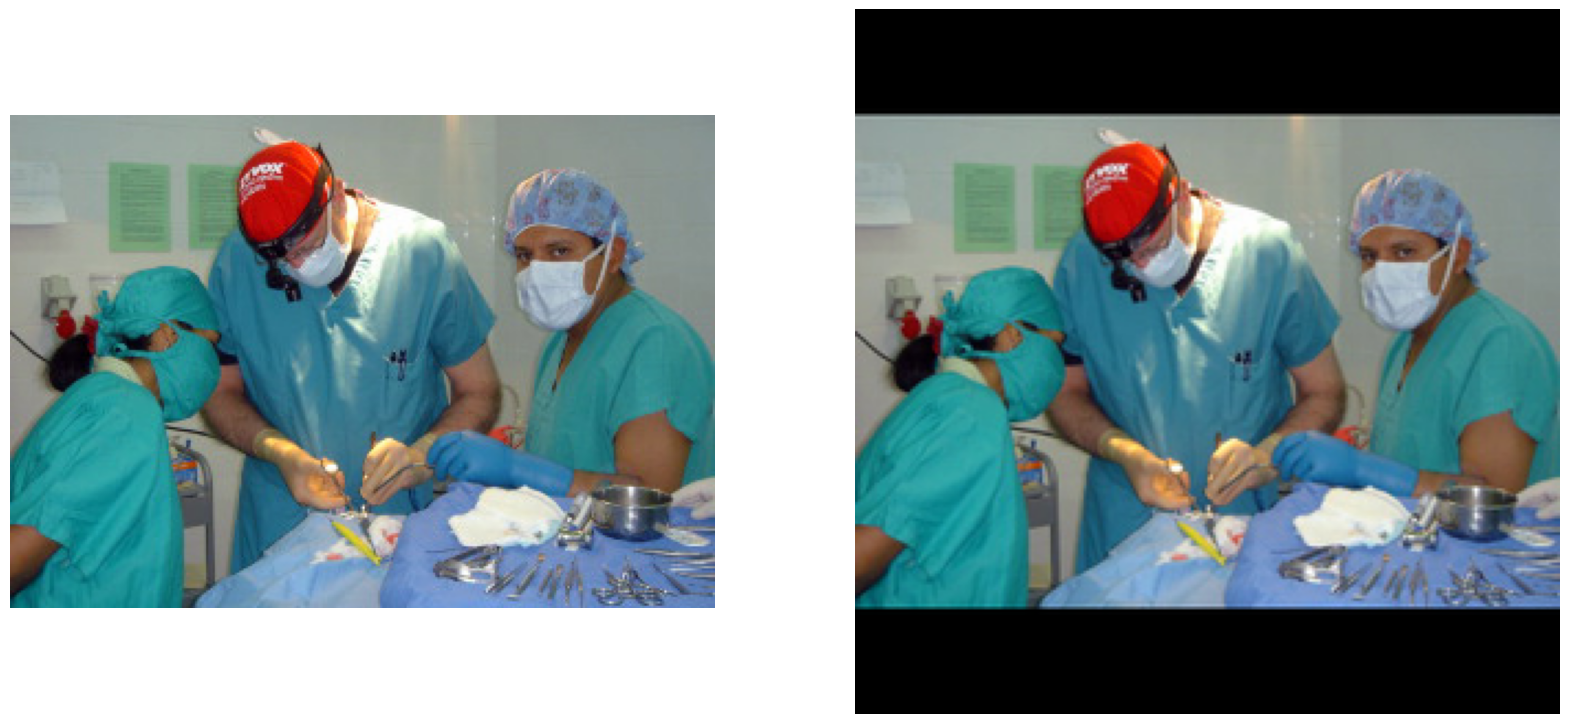

Map:  40%|████      | 4/10 [00:00<00:00,  8.07 examples/s]

(245, 500, 3)
(500, 500, 3)


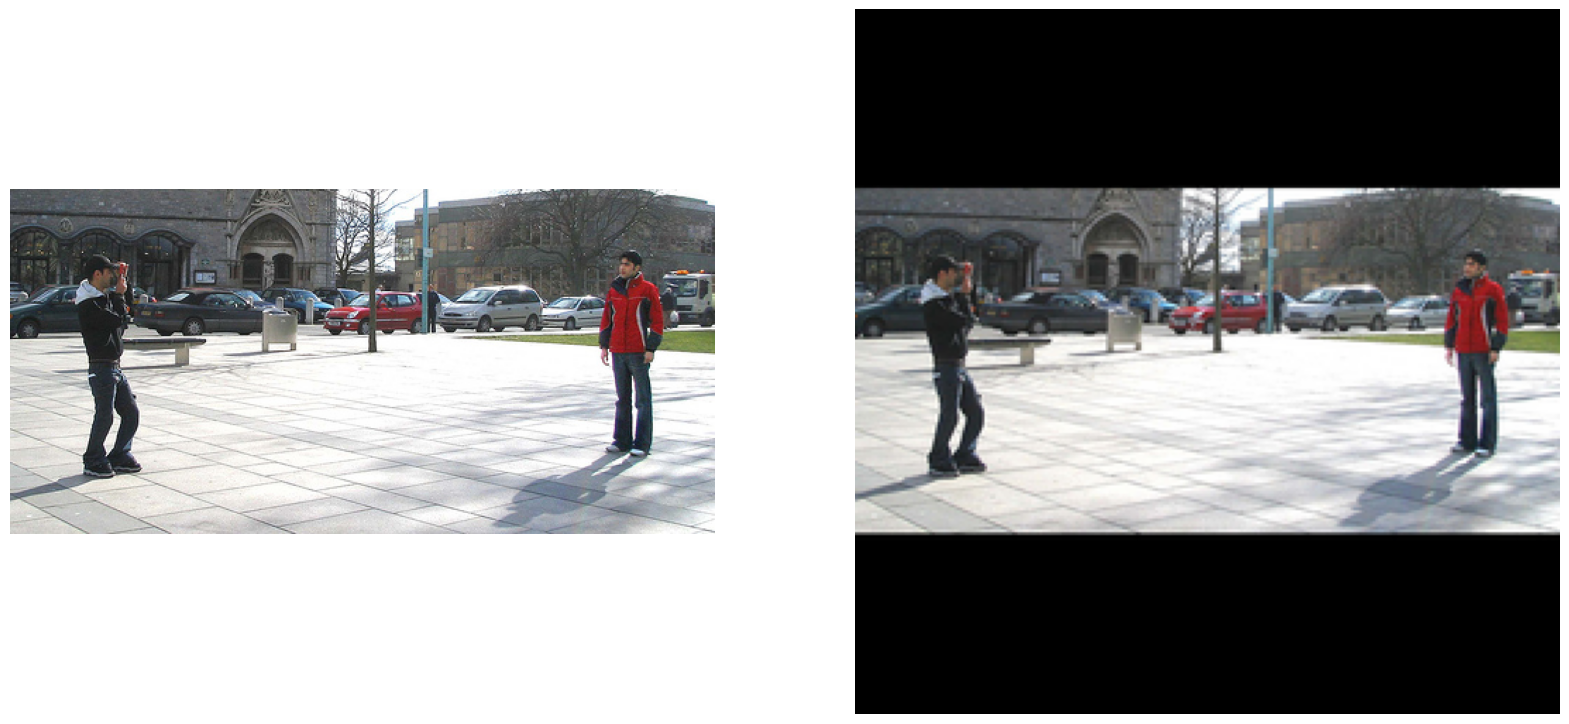

Map:  50%|█████     | 5/10 [00:00<00:00,  8.28 examples/s]

(167, 500, 3)
(500, 500, 3)


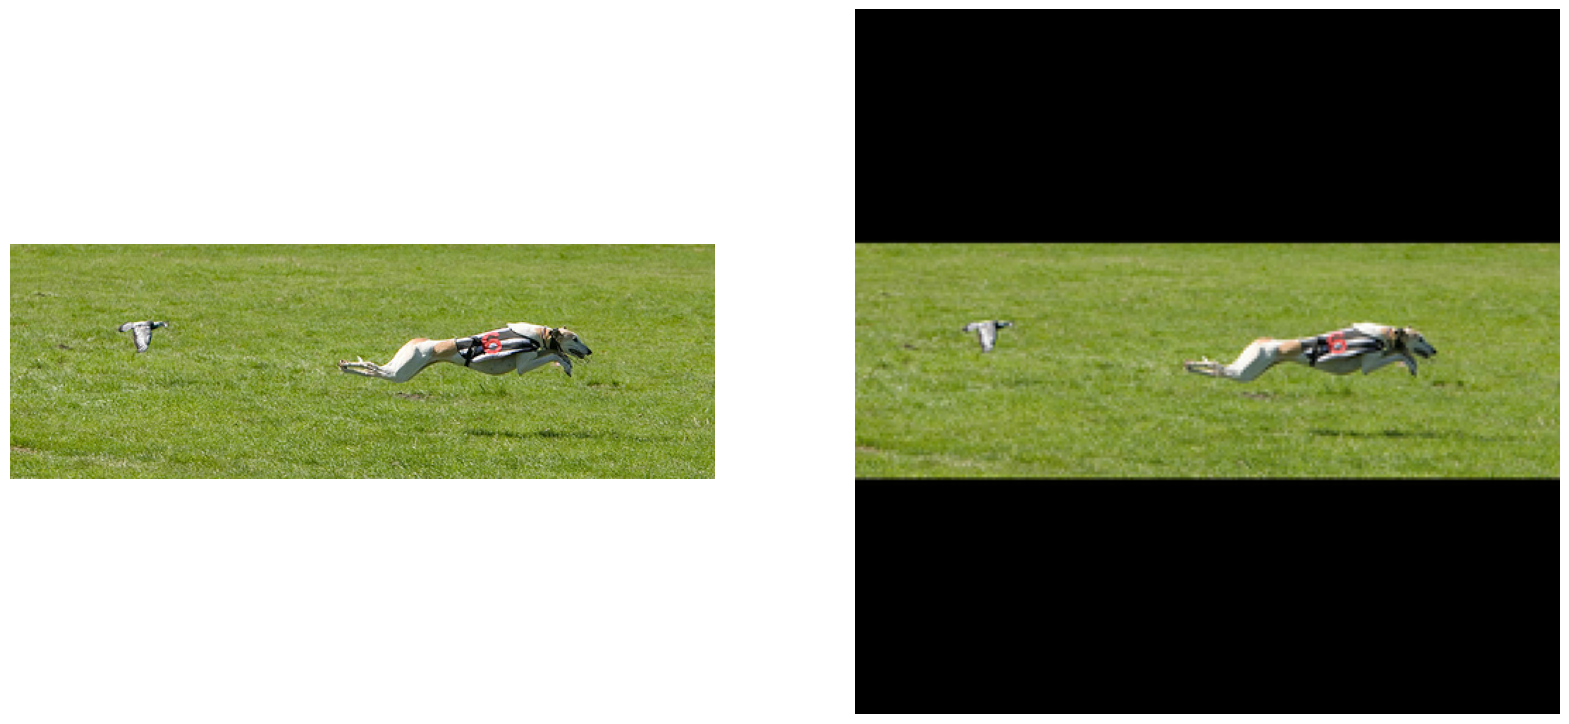

Map:  60%|██████    | 6/10 [00:00<00:00,  7.75 examples/s]

(233, 500, 3)
(500, 500, 3)


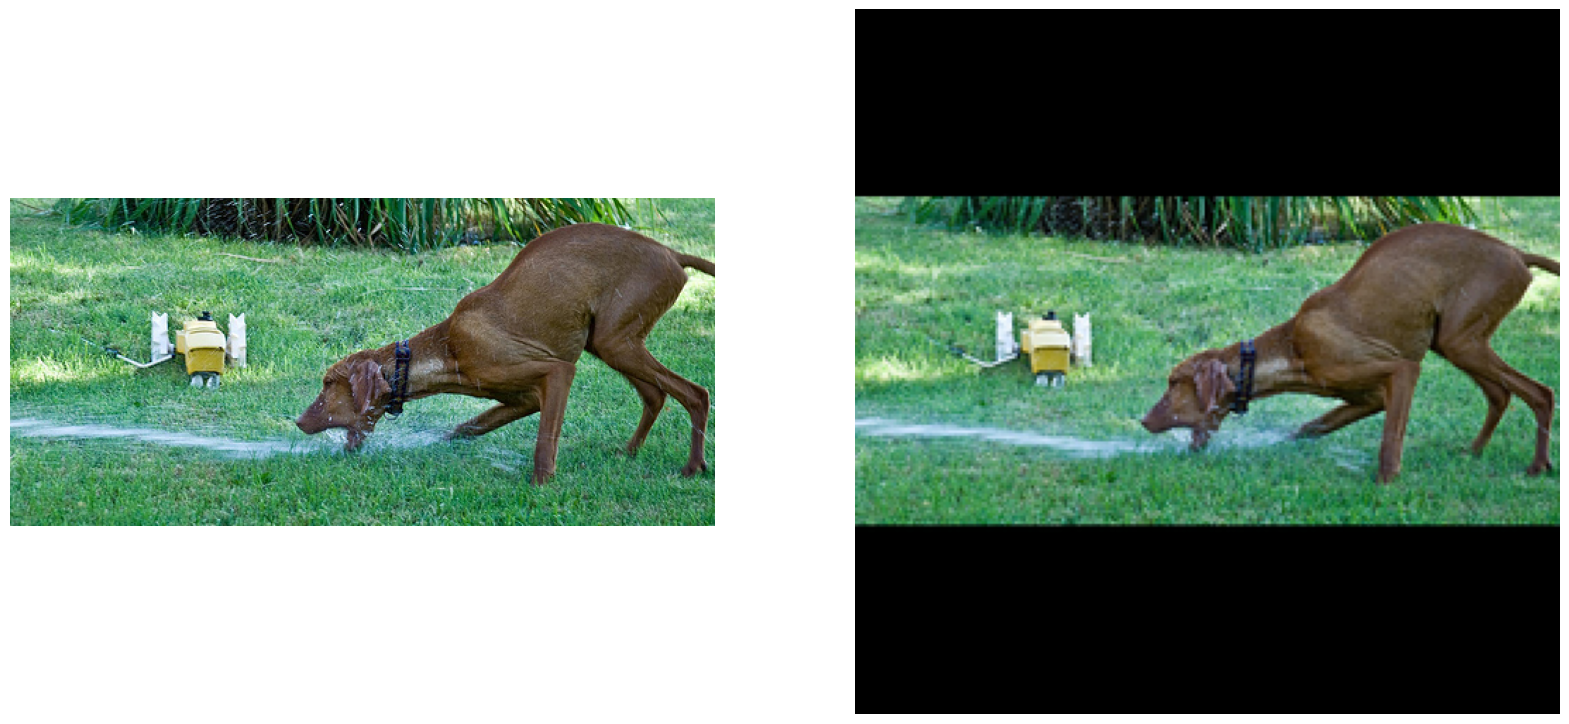

Map:  70%|███████   | 7/10 [00:00<00:00,  7.30 examples/s]

(185, 500, 3)
(500, 500, 3)


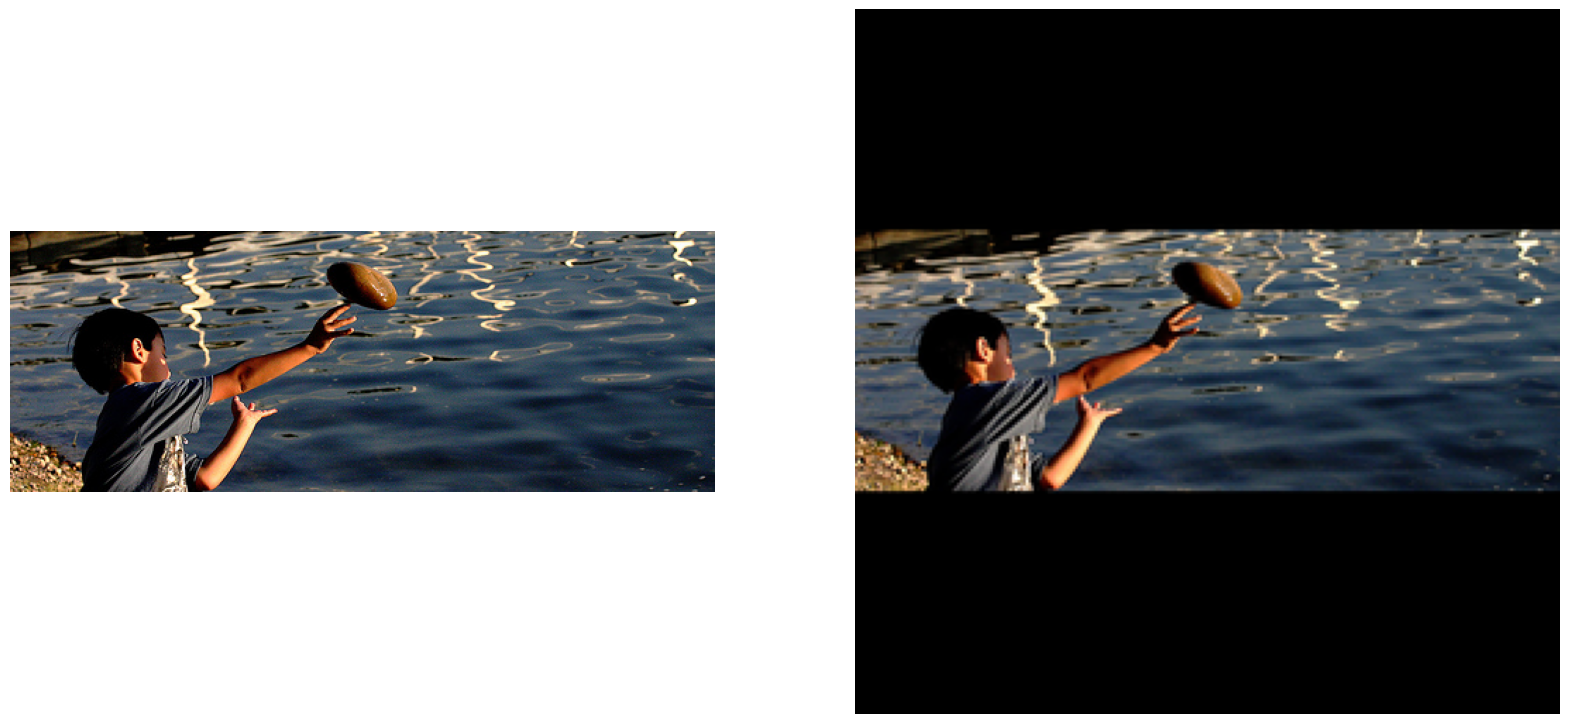

(252, 500, 3)
(500, 500, 3)


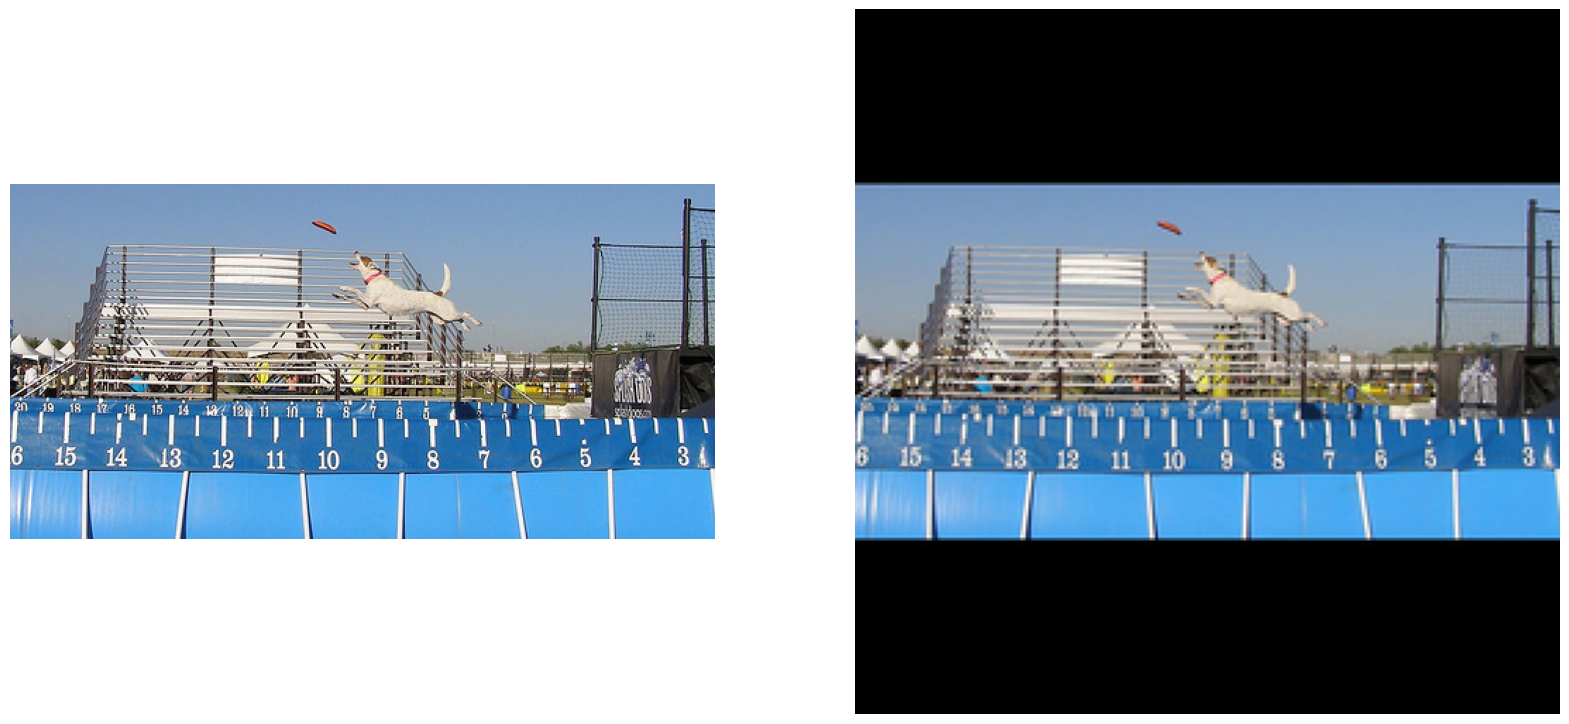

Map:  90%|█████████ | 9/10 [00:01<00:00,  5.88 examples/s]

(217, 500, 3)
(500, 500, 3)


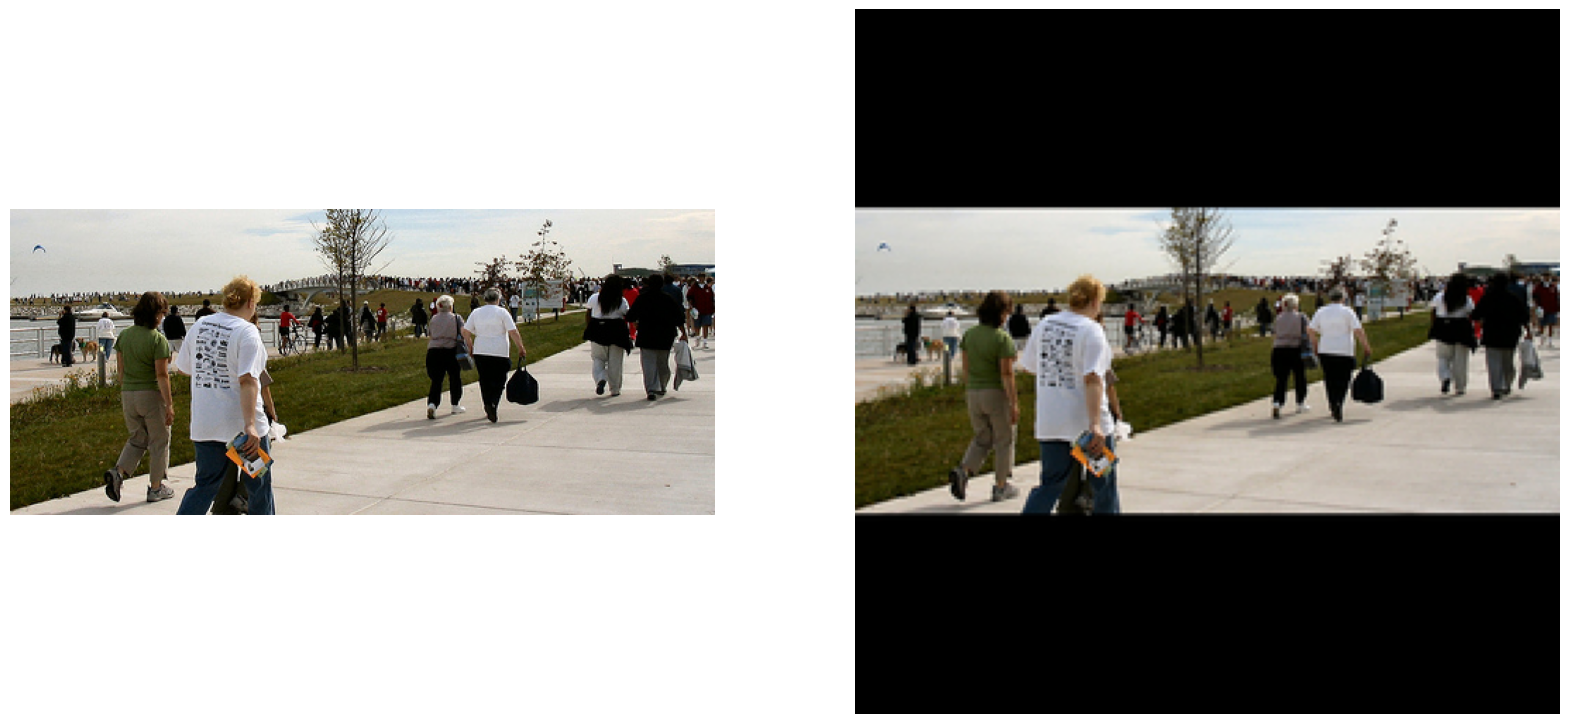

Map: 100%|██████████| 10/10 [00:01<00:00,  6.35 examples/s]/Users/amirjabarivasal/Documents/MLX/week4/week4/lib/python3.12/site-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Map: 100%|██████████| 10/10 [00:05<00:00,  1.81 examples/s]


In [83]:
def resize_and_pad_image(image, target_size=256):

    height, width, channels = image.shape 
    

    max_dim = max(height, width)
    square_image = np.full((max_dim, max_dim, channels), 0, dtype=np.uint8)
    
    # Calculate padding for centering
    y_offset = (max_dim - height) // 2
    x_offset = (max_dim - width) // 2
    
    # Place the original image in the center of the square
    square_image[y_offset:y_offset + height, x_offset:x_offset + width] = image
    print(square_image.shape)

    height, width, channels = square_image.shape
    scale = min(target_size/width, target_size/height)
    
    # Calculate new dimensions
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    # Create PIL image for resizing (better quality than cv2 or scipy)
    pil_image = Image.fromarray(square_image)

    resized_image = pil_image.resize((new_width, new_height), Image.LANCZOS)  # Fixed this line
    resized_array = np.array(resized_image)
    # print(resized_array.shape, 'resized array')
    # Create new white background array
    padded_array = np.full((target_size, target_size, 3), 0, dtype=np.uint8)
    
    # Calculate position to paste resized image (center)
    paste_y = (target_size - new_height) // 2 
    paste_x = (target_size - new_width) // 2
    
    # Paste resized image onto white background
    padded_array[paste_y:paste_y + new_height, paste_x:paste_x + new_width] = resized_array

    processed_image = Image.fromarray(padded_array)
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Display original image
    ax1.imshow(image)
    ax1.axis('off')
    
    # Display processed image
    ax2.imshow(processed_image)
    ax2.axis('off')
    
    plt.show()
    
    return padded_array

# Transform function for the dataset
def transform_images(examples):
    image = examples['image']
    print(image.shape)
    processed_image = resize_and_pad_image(image)
    return {
        'image': examples['image'],  # Keep original image
        'image_processed': processed_image,  # Add processed image
        'caption': examples['caption']  # Keep other fields
    }

transformed_images = sample.map(transform_images)

In [104]:
# print(transformed_images[0]['image_processed'][89])
# print(sample[0]['image_processed'].shape)
print(transformed_images[0]['img_id'])


9


In [10]:
def split_image_to_patches(image, image_height, image_width, patch_size, channels = 3):
    blocks = []
    num_patches = image_height // patch_size
    image = np.array(image)  # This will give you a (3, 224, 224) numpy array
    print(image.shape)
    for c in range(channels):
        for i in range(num_patches):
            for j in range(num_patches):
                #left to right, top to bottom
                block = image[c, i*patch_size : (i+1)*patch_size , j*patch_size : (j+1)*patch_size]
                blocks.append(block)
    return blocks

In [ ]:
# dataset2 = load_dataset("nlphuji/flickr30k")


# # Apply the transformation while keeping original images
# dataset_real_images = dataset2.map(transform_images)

Map:  10%|▉         | 2999/31014 [01:14<01:53, 246.14 examples/s] 

In [11]:
from PIL import ImageOps
dataset = load_dataset("nlphuji/flickr30k")
dataset = dataset['test'].select(range(100))

def make_square(image):
    # Make image square
    size = max(image.size)
    new_image = ImageOps.pad(image, (size, size), color='white')
    new_image = new_image.resize((256, 256))
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # ax[0].imshow(image, cmap='gray')
    # ax[1].imshow(new_image, cmap='gray')
    # plt.show()
    return new_image

def transform_images(examples):
    image = examples['image']
    processed_image = np.array(make_square(image))
    return {
        'image': examples['image'],  # Keep original image
        'image_processed': processed_image,  # Add processed image
        # 'caption': examples['caption']  # Keep other fields
    }

transformed_images = dataset.map(transform_images)


In [2]:
import transformers
import torch


In [144]:
token_ids = clipProcessor(text=["a photo of a cat"], return_tensors="pt", padding=True)
token_ids = token_ids['input_ids']
textmodel = CLIP.text_model
textmodel.eval()
clipProcessor.tokenizer("hello i am a dog")

{'input_ids': [49406, 3306, 328, 687, 320, 1929, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [12]:
CLIP = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

tokenizer = processor.tokenizer

# Access vocabulary
vocab = tokenizer.get_vocab()  # Returns dict of {token: index}
vocab_size = tokenizer.vocab_size  # Get total vocabulary size

text_model = CLIP.text_model

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        dataset = self.dataset[idx]
        image = dataset['image_processed'] #height, width, channels
        captions = dataset['caption']
        
        patches_array = split_image_to_patches(image, image.shape[0], image.shape[1], 32, 3)
        patches_tensor = [torch.tensor(patch.flatten(), dtype=torch.float32) for patch in patches_array] 
        image_tensor = torch.stack(patches_tensor)


        
        random_caption_idx = torch.randint(0, len(captions), (1,)).item()
        selected_caption = captions[random_caption_idx]
        tokenized_caption = tokenizer(selected_caption, return_tensors="pt", padding=True)

        
        
        return {
            'image': image_tensor,
            'caption': tokenized_caption['input_ids'],
        }

In [13]:
reverse_vocab = {idx: token for token, idx in vocab.items()}  # {index: token}

# Now you can look up tokens by index like this:
# Example usage:
print(reverse_vocab[49406])

<|startoftext|>


In [14]:
datasetclass = Dataset(transformed_images)

In [26]:
from torch import nn
import copy
import math



class Transformer(nn.Module):
    def __init__(self, d_model, text_encoder, image_encoder, decoder, tgt_vocab_size):
        super(Transformer, self).__init__()

        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.decoder = decoder

        self.fc = nn.Linear(tgt_vocab_size, tgt_vocab_size)

    def forward(self, image, caption):
        print(caption.shape, "caption.shape")
        text_encoder_output = self.text_encoder.forward(caption)
        # print(text_encoder_output)
        # print(text_encoder_output.shape, "text_encoder_output.shape")
        image_encoder_output = self.image_encoder.forward(image)
        # print(image_encoder_output.last_hidden_state, "image_encoder_output.shape")
        # print(text_encoder_output.shape, image_encoder_output.shape)
        dec_output = self.decoder.forward(text_encoder_output, image_encoder_output.last_hidden_state)

        output = self.fc(dec_output)
        return output


def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class DecoderLayer(nn.Module):
    def __init__(self, input_dim, tgt_vocab_size, intermediate_attn_dim, n_loops, feed_forward, self_attn_layer, cross_attn_layer):
        super(DecoderLayer, self).__init__()
        self.self_attn_layer = self_attn_layer
        self.cross_attn_layer = cross_attn_layer
        self.FF_layer = feed_forward
        self.tgt_vocab_size = tgt_vocab_size
        self.input_dim = input_dim
        self.n_loops = n_loops

        self.projectbacktovocab = torch.nn.Linear(intermediate_attn_dim, tgt_vocab_size)

        self.norm1 = torch.nn.LayerNorm(tgt_vocab_size)
        self.norm2 = torch.nn.LayerNorm(tgt_vocab_size)
        self.norm3 = torch.nn.LayerNorm(tgt_vocab_size)

    def forward(self, x, encoder_output, mask):
        embedding = x
        attn, prob = self.self_attn_layer.forward(embedding, embedding, embedding, mask)
        x = self.norm1(attn + embedding)
        attn, prob = self.cross_attn_layer.forward(query_input=x, key_input=encoder_output, value_input=encoder_output)
        attn = self.projectbacktovocab(attn)
        x = self.norm2(x + attn)

        ff_output = self.FF_layer(x)
        x = self.norm3(x + ff_output)
        return x

class Decoder(nn.Module):
     def __init__(self, tgt_vocab_size, pad_token, embedding_layer, layer, n_loops):
        super(Decoder, self).__init__()
        self.embedding_layer = embedding_layer #convert token IDs to embeddings
        self.pad_token = pad_token
        self.norm1 = torch.nn.LayerNorm(tgt_vocab_size)
        self.layers = clones(layer, n_loops)


     def forward(self, x, encoder_output):
        # mask = self.generate_padding_mask(x)
        mask = True
        print(x.shape, "x.shape")
        x = self.embedding_layer.forward(x)
        print(x, "x.shape")
        for layer in self.layers:
            x = layer(x, encoder_output, mask)
        x = self.norm1(x)
        return x
     
   

class Attention_Layer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(Attention_Layer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
    
    def forward(self, query_input, key_input, value_input, mask=None):
        dim_k = self.d_model // self.num_heads
        query = self.W_q(query_input)
        key = self.W_k(key_input)
        value = self.W_v(value_input)
        

        
        query_key = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(dim_k)

        if mask is not None:
            nopeak_mask = (1 - torch.triu(torch.ones(query_key.size(-2), query_key.size(-1)), diagonal=1)).bool()
            query_key = query_key.masked_fill(~nopeak_mask, float('-inf'))
            # print(mask.shape, 'mask.shape', query_key.shape)
            # query_key = query_key.masked_fill(~mask, float('-inf'))

        prob = query_key.softmax(dim=-1)
        weighted_attention = torch.matmul(prob, value)
        return weighted_attention, prob
    
class Cross_Attention_Layer(nn.Module):
    def __init__(self, encoder_output_dim, decoder_dim, d_model, num_heads):
        super(Cross_Attention_Layer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        self.W_q = torch.nn.Linear(decoder_dim, d_model)

        self.W_k = torch.nn.Linear(encoder_output_dim, d_model)
        self.W_v = torch.nn.Linear(encoder_output_dim, d_model)
    
    def forward(self, query_input, key_input, value_input, mask=None):
        dim_k = self.d_model // self.num_heads
        query = self.W_q(query_input)
        key = self.W_k(key_input)
        value = self.W_v(value_input)
        
        query_key = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(dim_k)
        prob = query_key.softmax(dim=-1)
        weighted_attention = torch.matmul(prob, value)
        return weighted_attention, prob


    

In [27]:
d_model = 512
text_dimension_embedding = 512
image_encoder_output_dim = 768

self_attn_layer = Attention_Layer(d_model=d_model, num_heads=1)
cross_attn_layer = Cross_Attention_Layer(encoder_output_dim=image_encoder_output_dim, decoder_dim=text_dimension_embedding, d_model=d_model, num_heads=1)

feed_forward = nn.Sequential(nn.Linear(d_model, 2048), nn.ReLU(), nn.Linear(2048, d_model))

text_model = CLIP.text_model
text_embedder = text_model.embeddings

decoder_layer = DecoderLayer(input_dim=text_dimension_embedding, tgt_vocab_size=vocab_size, intermediate_attn_dim=d_model, n_loops=6, feed_forward=feed_forward, self_attn_layer=self_attn_layer, cross_attn_layer=cross_attn_layer)



decoder = Decoder(vocab_size, pad_token="pad", embedding_layer=text_embedder, layer=decoder_layer, n_loops=6)


transformer = Transformer(d_model=d_model, text_encoder=text_embedder, image_encoder=CLIP.vision_model, decoder=decoder, tgt_vocab_size=vocab_size)


: 

In [179]:
reverse_vocab[0]

'!'

In [185]:
print(CLIP.text_model)
text = "a photo of a cat"
tokenized_text = tokenizer(text, return_tensors="pt", padding=True)
print(tokenized_text)

textmodel = CLIP.text_model
textmodel.eval()

text_encoder_output = textmodel(tokenized_text['input_ids'])
print(text_encoder_output.last_hidden_state.shape)

text_embedding = textmodel.embeddings
text_embedding.eval()

text_embedding_output = text_embedding(tokenized_text['input_ids'])
print(text_embedding_output.shape)






CLIPTextTransformer(
  (embeddings): CLIPTextEmbeddings(
    (token_embedding): Embedding(49408, 512)
    (position_embedding): Embedding(77, 512)
  )
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (final_layer_norm

In [ ]:

# clipProcessor.tokenizer("hello i am a dog")

torch.Size([1, 3, 224, 224])


In [21]:
image_processed = processor(images=[np.array(transformed_images[0]['image_processed'])], return_tensors="pt", padding=True)

# token_ids = token_ids['input_ids']
print(image_processed['pixel_values'].shape)
visionmodel = CLIP.vision_model
visionmodel.eval()
vision_output = visionmodel(image_processed['pixel_values'])


text = "a photo of a cat"
tokenized_text = tokenizer(text, return_tensors="pt", padding=True)
textmodel = CLIP.text_model
# textmodel.eval()

text_encoder_output = textmodel(tokenized_text['input_ids'])
print(text_encoder_output.last_hidden_state.shape)
last_hidden_state_text = text_encoder_output.last_hidden_state

torch.Size([1, 3, 224, 224])
torch.Size([1, 7, 512])


In [221]:
print(tokenized_text['input_ids'])

tensor([[49406,   320,  1125,   539,   320,  2368, 49407]])


In [25]:
transformer.eval()
print(image_processed['pixel_values'].shape, last_hidden_state_text.shape)
# token_ids['pixel_values']
print(type(tokenized_text['input_ids']), "tokenized_text['input_ids'].shape")
transformer.forward(image_processed['pixel_values'], tokenized_text['input_ids'])

torch.Size([1, 3, 224, 224]) torch.Size([1, 7, 512])
<class 'torch.Tensor'> tokenized_text['input_ids'].shape
torch.Size([1, 7]) caption.shape
tensor([[[-0.0031,  0.0003, -0.0083,  ..., -0.0071, -0.0074,  0.0001],
         [-0.0068, -0.0069, -0.0059,  ..., -0.0019,  0.0113, -0.0091],
         [ 0.0176,  0.0173, -0.0129,  ..., -0.0130,  0.0150, -0.0159],
         ...,
         [-0.0053, -0.0080, -0.0077,  ..., -0.0049,  0.0081, -0.0080],
         [-0.0194,  0.0016, -0.0142,  ...,  0.0026,  0.0187, -0.0156],
         [-0.0105,  0.0036, -0.0012,  ..., -0.0053, -0.0083, -0.0010]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 7, 512]) text_encoder_output.shape
tensor([[[ 0.2525,  0.0631,  0.0922,  ...,  0.3510,  0.1261,  0.0057],
         [ 0.1011,  0.2556, -0.0308,  ..., -0.0040,  0.5900,  0.1668],
         [-0.2044,  0.2853, -0.3704,  ..., -0.0785,  0.5542, -0.3233],
         ...,
         [ 1.0056,  0.4216, -0.4546,  ..., -0.2466, -0.2254,  0.3197],
         [ 0.4106,  1.1397,  0.1396,

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [20]:
textmodel(tokenized_text['input_ids'])
print(CLIP)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e